# PreProcessing points coordinate

In [1]:
import numpy as np

x_min, x_max = -0.5, 1.5
z_min, z_max = -1, 1
res = 128

x_values = np.linspace(x_min, x_max, res)
z_values = np.linspace(z_min, z_max, res)
y_values = [0.2, 0.65, 0.8, 0.9, 0.96, 0.99]

write_path = 'system/include/AIP'
with open('system/include/AIP', 'w') as file:
    file.write("pts\n(\n")
    for z in z_values:
        for y in y_values:
            y *= 1.1963
            for x in x_values:
                file.write(f"({x} {y} {z})\n")
    file.write(");")
print(f'Write the surface points in {write_path} file.')

Write the surface points in system/include/AIP file.


# PostProcessing

## InternalProbes

In [22]:
import numpy as np
import pandas as pd
file_path = 'postProcessing/internalProbes/2000/points.xy'
postProcessing_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p','Ux','Uy','Uz'])
postProcessing_content

,x,y,z,p,Ux,Uy,Uz
0,5.000000,0.000000,5.000000,98833.0,292.330,0.000000,15.4676
1,5.000000,0.000000,4.286000,98857.3,292.298,0.000000,15.1830
2,5.000000,0.000000,3.569820,98869.3,292.291,0.000000,14.7780
3,5.000000,0.000000,2.827110,98882.9,292.303,0.000000,14.1063
4,5.000000,0.000000,2.146940,98908.3,292.302,0.000000,12.9258
...,...,...,...,...,...,...,...
1327200,0.044529,0.044547,-0.021352,107606.0,247.108,6.529520,-78.9177
1327201,0.044881,0.045373,-0.021309,107772.0,246.173,8.040850,-80.0629
1327202,0.051004,0.048010,-0.022837,105412.0,257.954,2.530210,-68.7869
1327203,0.055226,0.045278,-0.024238,103598.0,266.996,-1.738230,-57.5338


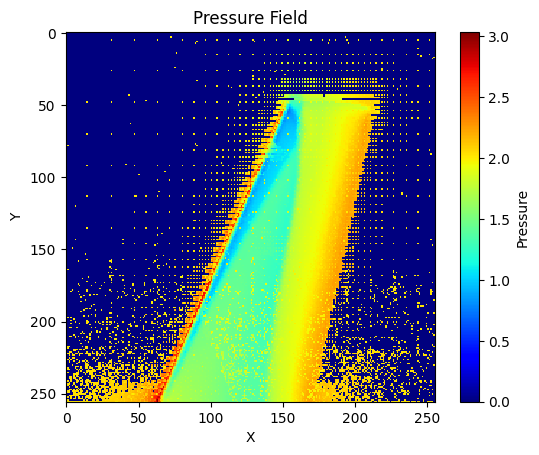

In [23]:
upper = postProcessing_content[(postProcessing_content['z'] >= 0.)]
selected_data = upper[(upper['x'] >= -0.5) & (upper['x'] <= 1.5) & (upper['y'] >= 0.) & (upper['y'] <= 1.5)]
x = selected_data['x']
y = selected_data['y']
p = selected_data['p']
pv = 0.5 * 1.151 * 292.67**2
normalized_x = (x + 0.5) / 2
normalized_y = y / 1.5
res = 256
npOutput = np.zeros((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_y * (res-1)).astype(int)] = p / pv
field = np.copy(npOutput)
field = np.flipud(field.transpose())

import matplotlib.pyplot as plt
plt.imshow(field, cmap='jet', interpolation='nearest')
plt.colorbar(label='Pressure')
plt.title('Pressure Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


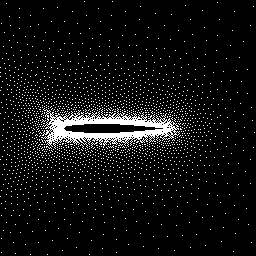

In [25]:
from matplotlib import colormaps
from matplotlib import cm
from PIL import Image
# y0_df = postProcessing_content[(postProcessing_content['y'] <= 0.23926 + 1e-3) & (postProcessing_content['y'] >= 0.23926 -1e-3)]
y0_df = postProcessing_content[(postProcessing_content['y'] <= 1e-3) & (postProcessing_content['y'] >= -1e-3)]
# 從 DataFrame 中選擇 x 和 z 值在 -2 到 2 區間內的數據
selected_data = y0_df[(y0_df['x'] >= -0.5) & (y0_df['x'] <= 1.5) & (y0_df['z'] >= -1) & (y0_df['z'] <= 1)]

x = selected_data['x']
z = selected_data['z']
p = selected_data['p']

res = 256
normalized_x = (x + 0.5) / 2
normalized_z = (z + 1 ) / 2
npOutput = np.zeros((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_z * (res-1)).astype(int)] = p

field = np.copy(npOutput)
field = np.flipud(field.transpose())

# min_value = np.min(field)
# max_value = np.max(field)
# field -= min_value
# max_value -= min_value
# field /= max_value

# im = Image.fromarray(cm.magma(field, bytes=True))
# im = im.resize((512, 512))
# im.show()

import matplotlib.pyplot as plt
# plt.imshow(field, cmap='jet', interpolation='nearest')
# plt.colorbar(label='Pressure')
# plt.title('Pressure Field')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

im = Image.fromarray(field)
im.show()




In [1]:
# list(colormaps)

## BoundaryProbes

In [2]:
import pandas as pd
import numpy as np
# file_path = 'postProcessing/internalProbes/2000/points.xy'
# boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p','Ux','Uy','Uz']).round(5)
file_path = 'postProcessing/boundaryProbes/2000/points.xy'
boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p']).round(5)
rho = 1.184
v = 292.67
pv = 0.5 * rho * (v**2)
boundary_content['Cp'] = (boundary_content['p']-98858.97) / pv
def normalize(boundary_content):
    L = boundary_content['x'].max() - boundary_content['x'].min()
    lead = boundary_content['x'].min()
    boundary_content['X/L'] = (boundary_content['x'] - lead) / L
    return boundary_content

section = 0.9
y_coord = np.round(1.1963 * section,5)
of_df = boundary_content[(boundary_content['y'] <= y_coord + 1e-2) & (boundary_content['y'] >= y_coord - 1e-2)]
of_df = normalize(of_df)
exp_path = f"exp/exp{int(section * 100)}pc.csv"
exp_df = pd.read_csv(exp_path, delimiter='\s+', header=None, names=['Section','Tap','X/L','Z/L','Cp']).round(5)
# of_df.plot(kind='scatter',x='x',y='z')

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(exp_df['X/L'], exp_df['Cp'], color='red',alpha=0.7, label='Experiment', zorder=2)
plt.scatter(of_df['X/L'], of_df['Cp'], color='blue', label='OpenFOAM')
# plt.scatter(of_upper['X/L'], of_upper['Cp'], color='blue', marker='^', label='OpenFOAM upper')
# plt.scatter(of_lower['X/L'], of_lower['Cp'], color='blue', marker='v', label='OpenFOAM lower')

plt.xlabel('X/L')
plt.ylabel('Cp')
plt.title(f'Pressure coeff distribution at wing surface of section {section} spanwise')
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.legend()

# Residual plot

In [15]:
import re
log_path = 'log/hisa.log'
with open(log_path,'r') as file:
    log_content = file.read()
GMRES_pattern = r"GMRES iteration: 0\s+Residual:\s+([0-9.]+)"
GMRES_matches = re.findall(GMRES_pattern, log_content)
omega_pattern = r"Solving for omega, Initial residual = ([0-9.eE+-]+)"
omega_matches = re.findall(omega_pattern, log_content)
k_pattern = r"smoothSolver:  Solving for k, Initial residual = ([0-9.eE+-]+)"
k_matches = re.findall(k_pattern, log_content)

if GMRES_matches:
    GMRES_residual = [float(value) for value in GMRES_matches]
else:
    print("No GMRES matches found")

if omega_matches:
    omega_residual = [float(value) for value in omega_matches]
else:
    print("No matches found for Omega Initial residual")

if k_matches:
    k_residual = [float(value) for value in k_matches]
else:
    print("No matches found for K Initial residual")

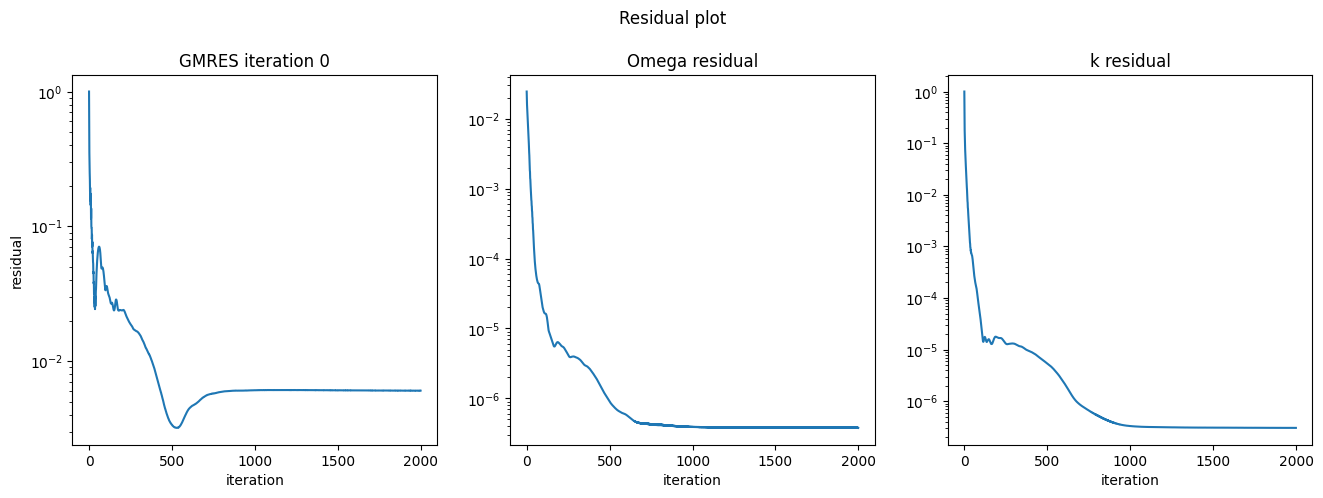

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].semilogy(GMRES_residual)
axes[0].set_title('GMRES iteration 0')
axes[0].set_ylabel('residual')
axes[0].set_xlabel('iteration')
axes[1].semilogy(omega_residual)
axes[1].set_title('Omega residual')
axes[1].set_xlabel('iteration')
axes[2].semilogy(k_residual)
axes[2].set_title('k residual')
axes[2].set_xlabel('iteration')

fig.suptitle('Residual plot')
plt.subplots_adjust(top=0.85)